# Prepare synthetic data

- Zella King
- 2022-09-30

Our goal is to develop a Bayesian model to predict a patient's probability of being discharged in the next 24 hours. 

Here are three initial steps I think we need to do: 

 1. Decide on our "prior" probability and express it as a distribution 
 2. Identify some data we can use for the "likelihood". This can be synthetic to start with
 3. Develop a posterior distribution from the prior and likelihood. 

 In this example I'm using terminology and  methods from here: https://allendowney.github.io/ThinkBayes2/chap06.html

In [70]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson, lognorm
import sqlalchemy as sa

from empiricaldist import Pmf

In [2]:
%matplotlib inline

## Prior odds

Previously we found, by interrogating some synthetic data, that a patient's probability of discharge in the next 24 hours was .1111. Let's call this a probability of 1/9

We could express this as odds. For everyone 1 patient discharged, 8 remain. Therefore the odds of discharge are 1:8 or 0.125. 


In [3]:
def odds(p):
    return p / (1-p)

odds (1/9)

def prob(o):
    return o / (o+1)

## Likelihood


In probability form, Bayes theorem is this:

$ P(H | D) =\frac{P(H)P(D|H)}{P(D)}$

It can be rewritten in terms of odd (Bayes rule).  We can express the odds in favour of discharge as:

$ odds(discharge | data) =odds (discharge) * \frac{P( data | discharge)}{P( data | not discharged)}$

We will read in the dummy data to get the likelihood. Note that this table of synthetic data has been adjusted to make it more likely that older people have a longer time to discharge

In [9]:
sqlite_engine = sa.create_engine('sqlite:///../../data/dummy.db')
df = pd.read_sql_query("SELECT id, hours_to_discharge, department, age, pulse from discharges_age_adjusted", sqlite_engine)

# Let N be the number of patients observed
N = df.shape[0]

# Let X be the number of patients who were discharged in 24 hours
X = df[df.hours_to_discharge <= 24].shape[0]
print("Number of people discharged in 24 hours: " + str(X))
print("Total number of people observed: " + str(N))

Number of people discharged in 24 hours: 32
Total number of people observed: 444


Let's group age into two categories (over 65 or not) and identify which ones were actually discharged in 24 hours. Then, cross-tabulating them:

In [10]:
df

,id,hours_to_discharge,department,age,pulse
0,0,36.000000,UCH T07 SOUTH,35.0,78.0
1,1,456.573401,UCH T14 NORTH TRAUMA,60.0,98.0
2,2,NaN,UCH T10 SOUTH (T10S),70.0,76.0
3,3,17.000000,UCH T11 SOUTH (T11S),55.0,104.0
4,4,NaN,UCH T01 ACUTE MEDICAL,35.0,68.0
...,...,...,...,...,...
439,439,NaN,UCH T06 HEAD (T06H),70.0,74.0
440,440,NaN,UCH SDEC,35.0,76.0
441,441,213.938412,UCH T16 SOUTH WINTER,65.0,NaN
442,442,346.482699,UCH T12 NORTH (T12N),60.0,55.0


In [11]:
df['agegp'] = df['age'].apply(lambda x:  'gt65' if x>65 else 'lte65')
df['dischargein24'] = df.hours_to_discharge <= 24
pivot = df.groupby('agegp')['dischargein24'].value_counts().to_frame().rename(columns = {'dischargein24':'N'})
pivot.reset_index().pivot(columns = 'dischargein24', index = 'agegp', values = 'N')



dischargein24,False,True
agegp,,
gt65,179,6
lte65,233,26


## Posterior

Let's say we are looking at one patient of the 444 and this person is over 65. We want to know whether this person will be discharged in the next 24 hours. These posterior odds are given by this equation: 

$ odds(discharge | over65 ) =odds (discharge) * \frac{P( over65 | discharge)}{P( over65 | not discharged)}$



In [153]:
likelihood_gt65_given_dis = df[(df.dischargein24) & (df.agegp == 'gt65')].shape[0] / df[df.dischargein24].shape[0]
print(likelihood_gt65_given_dis)

0.1875


$ P( over65 | not discharged)$ is:

In [13]:
likelihood_lte65_given_dis = df[~(df.dischargein24) & (df.agegp == 'gt65')].shape[0] / df[~df.dischargein24].shape[0]
print(likelihood_lte65_given_dis)

0.4344660194174757


Likelihood ratio, given by $  \frac{P( over65 | discharge)}{P( over65 | not discharged)}$ is:

In [155]:
likelihood_gt65_given_dis/likelihood_lte65_given_dis

0.43156424581005587

In [157]:
prior_odds = 1/8
likelihood_ratio = likelihood_gt65_given_dis/likelihood_lte65_given_dis
print(likelihood_ratio)
post_odds = prior_odds * likelihood_ratio
post_odds

0.43156424581005587


0.053945530726256984

The posterior odds, given a patient is over 65 are substantially reduced 

## Using Allen Downey functions

In [141]:
bindex = ['prior']
table = pd.DataFrame(index = index)
table['odds'] = 1/8
table['prob'] = prob(table['odds'])
table

table

,odds,prob
lte65,0.125,0.111111
gt65,0.125,0.111111


In [142]:
index = ['lte65', 'gt65']
table = pd.DataFrame(index = index)
table['odds'] = 1/8
table['prob'] = prob(table['odds'])
table



,odds,prob
lte65,0.125,0.111111
gt65,0.125,0.111111


Adding the likelihood we computed earlier:

Calculating the posterior odds for both groups

In [143]:
table_ = table.reset_index().rename(columns= {'index': 'agegp'})


In [144]:
table_

,agegp,odds,prob
0,lte65,0.125,0.111111
1,gt65,0.125,0.111111


In [158]:
def get_lr(agegp_):
    l_dis = df[(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[df.dischargein24].shape[0]
    l_not_dis = df[~(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[~df.dischargein24].shape[0]
    lr = l_dis/l_not_dis
    return lr

table_['likelihood ratio'] = table_['agegp'].apply(lambda x: get_lr(x))
table_['posterior odds'] = table_['likelihood ratio']*table_['odds']
table_['posterior prob'] = prob(table_['posterior odds'])

In [159]:
table_

,agegp,odds,prob,likelihood ratio,posterior odds,posterior prob
0,lte65,0.125,0.111111,1.436695,0.179587,0.152246
1,gt65,0.125,0.111111,0.431564,0.053946,0.051184


In [130]:
agegp_ = 'lte65'
l_dis = df[(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[df.dischargein24].shape[0]
l_not_dis = df[~(df.dischargein24) & (df.agegp == agegp_)].shape[0] / df[~df.dischargein24].shape[0]
lr = l_dis/l_not_dis
lr

1.4366952789699572

## Now try a logistic regression


In [69]:
# from Allen Downey github here https://github.com/AllenDowney/ThinkBayes2/blob/master/soln/utils.py
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution.
    
    qs: quantities
    name: string name for the quantities
    options: passed to Pmf
    
    returns: Pmf
    """
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

def make_joint(s1, s2):
    """Compute the outer product of two Series.
    
    First Series goes across the columns;
    second goes down the rows.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

# modified from https://allendowney.github.io/ThinkBayes2/chap16.html
    
def plot_data(data):
    """Plot damage as a function of temperature.
    
    data: DataFrame
    """
    plt.plot(data['age'], data['dischargein24'], 'o', 
             label='data', color='C0', alpha=0.4)

    decorate(ylabel="Discharged in 24 hours",
         xlabel="Age",
         title="Age by probability")

def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.
    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d


def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    low = joint.to_numpy().min()
    high = joint.to_numpy().max()
    levels = np.linspace(low, high, 6)
    levels = levels[1:]
    
    underride(options, levels=levels, linewidths=1)
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs


def marginal(joint, axis):
    """Compute a marginal distribution.
    
    axis=0 returns the marginal distribution of the first variable
    axis=1 returns the marginal distribution of the second variable
    
    joint: DataFrame representing a joint distribution
    axis: int axis to sum along
    
    returns: Pmf
    """
    return Pmf(joint.sum(axis=axis))

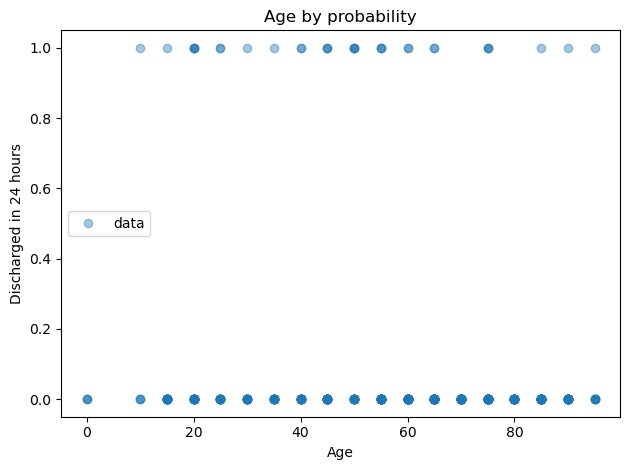

In [31]:
plot_data(df)

Based on this, there does not appear to be much of a relationship between age and probability of discharge. Nonetheless, let's assume this probability follows a logistic model. 

$ \log odds(discharge | age ) = \beta_{0} + \beta_{1} age $



### Conventional logistic regression 

In [14]:
age_offset = df['age'].mean().round()
df['x'] = df['age'] - age_offset
df['y'] = df['dischargein24'].apply(lambda x: 1 if x else 0)

import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=df[['x', 'y']]).fit(disp=False)
results.params

Intercept   -2.659918
x           -0.021289
dtype: float64

Checking, the exponential of the intercept to see the probability for age when it is at its median value. 

In [48]:
from scipy.special import expit
expit(results.params['Intercept'])

0.06538034246242286

We can use these parameters to compute probabilities for a range of ages. 

In [45]:
inter = results.params['Intercept']
slope = results.params['x']
xs = np.arange(df.age.min(), df.age.max()) - age_offset
log_odds = inter + slope * xs


And then convert to probabilities

In [47]:
odds = np.exp(log_odds)
ps = odds / (odds + 1)
ps

array([0.19720258, 0.19385397, 0.19054871, 0.18728672, 0.18406788,
       0.18089204, 0.17775905, 0.17466876, 0.17162098, 0.16861552,
       0.16565216, 0.16273069, 0.15985087, 0.15701246, 0.1542152 ,
       0.15145882, 0.14874304, 0.14606757, 0.14343212, 0.14083638,
       0.13828003, 0.13576275, 0.1332842 , 0.13084406, 0.12844196,
       0.12607757, 0.12375053, 0.12146046, 0.11920701, 0.1169898 ,
       0.11480846, 0.11266259, 0.11055183, 0.10847578, 0.10643405,
       0.10442624, 0.10245197, 0.10051084, 0.09860244, 0.09672638,
       0.09488226, 0.09306968, 0.09128823, 0.08953751, 0.08781712,
       0.08612666, 0.08446573, 0.08283393, 0.08123085, 0.07965611,
       0.0781093 , 0.07659002, 0.07509789, 0.07363251, 0.07219349,
       0.07078045, 0.06939299, 0.06803074, 0.06669332, 0.06538034,
       0.06409144, 0.06282624, 0.06158437, 0.06036547, 0.05916917,
       0.05799512, 0.05684295, 0.05571232, 0.05460288, 0.05351428,
       0.05244618, 0.05139823, 0.05037012, 0.0493615 , 0.04837

In [40]:

ps = expit(inter + slope * xs)

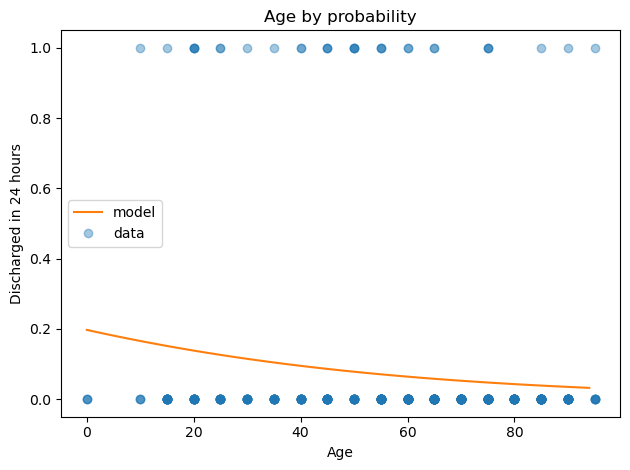

In [49]:
plt.plot(xs+age_offset, ps, label='model', color='C1')
plot_data(df)

### Bayesian logistic regression 

Using point estimates from the previous section to help determine choices of starting values for the prior distribution. 

joint_pmf is a probability mass functio (Pmf) with two levels in the index, one for each parameter. That makes it easy to loop through possible pairs of parameters, as we’ll see in the next section

In [54]:
from empiricaldist import Pmf
qs = np.linspace(-5, 1, num=101)
prior_inter = make_uniform(qs, 'Intercept')

qs = np.linspace(-0.05, 0.01, num=101)
prior_slope = make_uniform(qs, 'Slope')

joint = make_joint(prior_inter, prior_slope)

joint_pmf = Pmf(joint.stack())
joint_pmf.head()


Slope  Intercept
-0.05  -5.00        0.000098
       -4.94        0.000098
       -4.88        0.000098
Name: , dtype: float64

To do the update, we have to compute the likelihood of the data for each possible pair of parameters.

To make that easier, I’m going to group the data by age, x, and count the number of discharges at each age. 

(Note that the dummy data has age rounded to 5 year increments)

In [56]:
grouped = df.groupby('x')['y'].agg(['count', 'sum'])
grouped.head()

,count,sum
x,,
-59.0,3,0
-49.0,4,1
-44.0,17,1
-39.0,20,4
-34.0,15,2


The result is a DataFrame with two columns: count is the number of patients at each age; sum is the number of discharges. To be consistent with the parameters of the binomial distributions, I’ll assign them to variables named ns and ks.



In [58]:
ns = grouped['count']
ks = grouped['sum']

To compute the likelihood of the data, let’s assume temporarily that the parameters we just estimated, slope and inter, are correct. We can use them to compute the probability of discharge at each age, like this:



In [59]:
xs = grouped.index
ps = expit(inter + slope * xs)

ps contains the probability of discharge for each age, according to the model.

Now, for each age we have ns, ps, and ks; we can use the binomial distribution to compute the likelihood of the data.





In [60]:
from scipy.stats import binom

likes = binom.pmf(ks, ns, ps)
likes

array([0.51738984, 0.38485624, 0.18599886, 0.16375333, 0.28947594,
       0.34543338, 0.33444133, 0.27446382, 0.18678911, 0.03077659,
       0.22153198, 0.25856194, 0.27095509, 0.08390327, 0.2071413 ,
       0.34982154, 0.34156717, 0.36412761, 0.1818935 ])

Each element of likes is the probability of seeing k discharges in n patients if the probability of discharge is p. The likelihood of the whole dataset is the product of this array.



In [61]:
likes.prod()

6.831374996979833e-13

In [62]:

likelihood = joint_pmf.copy()
for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood[slope, inter] = likes.prod() 
likelihood

Slope  Intercept
-0.05  -5.00         4.106178e-29
       -4.94         1.964790e-28
       -4.88         9.205627e-28
       -4.82         4.218222e-27
       -4.76         1.887979e-26
                        ...      
 0.01   0.76        1.008940e-176
        0.82        8.085172e-184
        0.88        4.625067e-191
        0.94        1.903363e-198
        1.00        5.680628e-206
Name: , Length: 10201, dtype: float64

In [63]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

1.7132597757564664e-14

In [64]:
pd.Series(posterior_pmf.max_prob(),
          index=['slope', 'inter'])

slope   -0.0212
inter   -2.6600
dtype: float64

If we unstack the posterior Pmf we can make a contour plot of the joint posterior distribution.



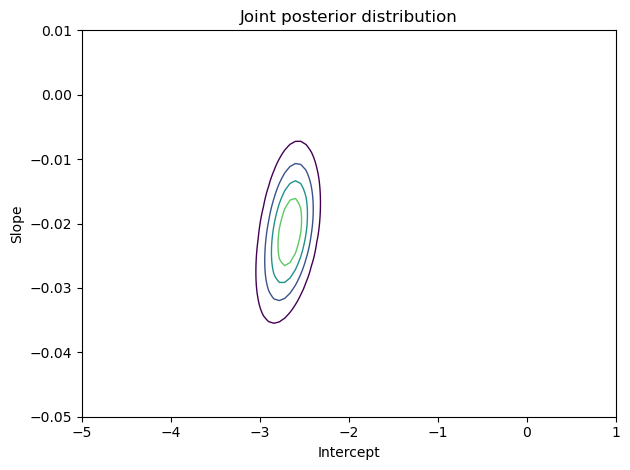

In [68]:
joint_posterior = posterior_pmf.unstack()
plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

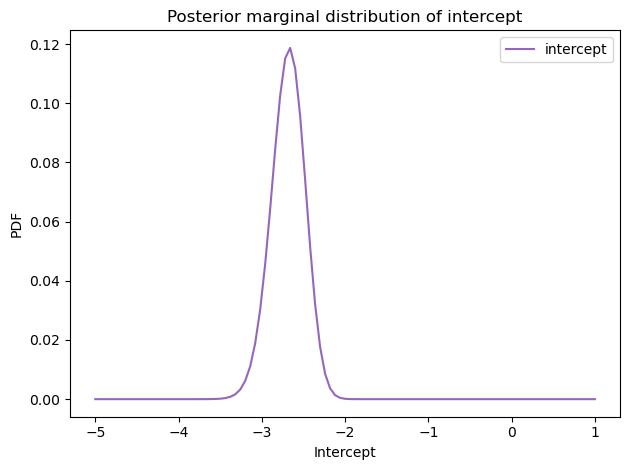

In [72]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.plot(label='intercept', color='C4')

decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

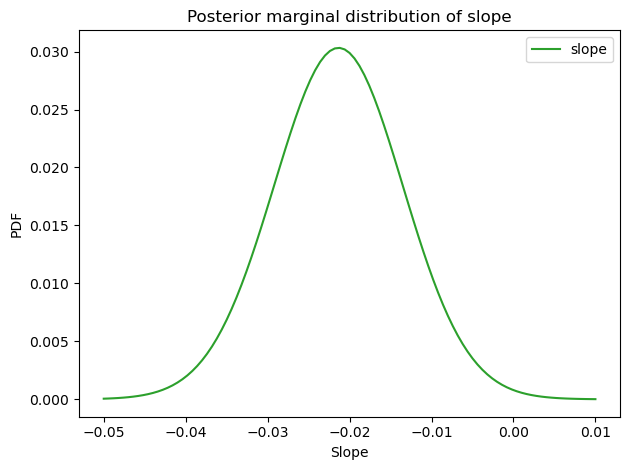

In [73]:
marginal_slope.plot(label='slope', color='C2')

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [74]:
pd.Series([marginal_inter.mean(), marginal_slope.mean()],
          index=['inter', 'slope'])

inter   -2.688931
slope   -0.021384
dtype: float64

In [75]:
marginal_probs = marginal_inter.transform(expit)


In [76]:
df.age.mean()

58.76126126126126

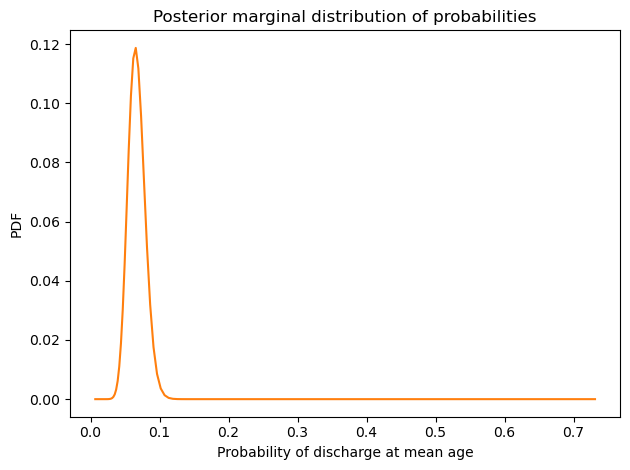

In [77]:
marginal_probs.plot(color='C1')

decorate(xlabel='Probability of discharge at mean age',
         ylabel='PDF',
         title='Posterior marginal distribution of probabilities')

In [78]:
posterior_pmf

Slope  Intercept
-0.05  -5.00         2.349481e-19
       -4.94         1.124217e-18
       -4.88         5.267292e-18
       -4.82         2.413590e-17
       -4.76         1.080267e-16
                        ...      
 0.01   0.76        5.772972e-167
        0.82        4.626188e-174
        0.88        2.646379e-181
        0.94        1.089070e-188
        1.00        3.250352e-196
Name: , Length: 10201, dtype: float64

## Predictive distribution

In [79]:
sample = posterior_pmf.choice(101)


In [80]:
ages = np.arange(df.age.min(), df.age.max())
xs = ages - age_offset

In [81]:
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)

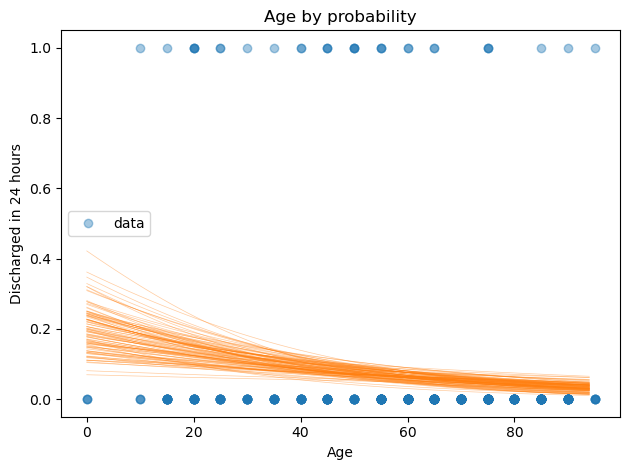

In [84]:
for ps in pred:
    plt.plot(ages, ps, color='C1', lw=0.5, alpha=0.4)
    
plot_data(df)

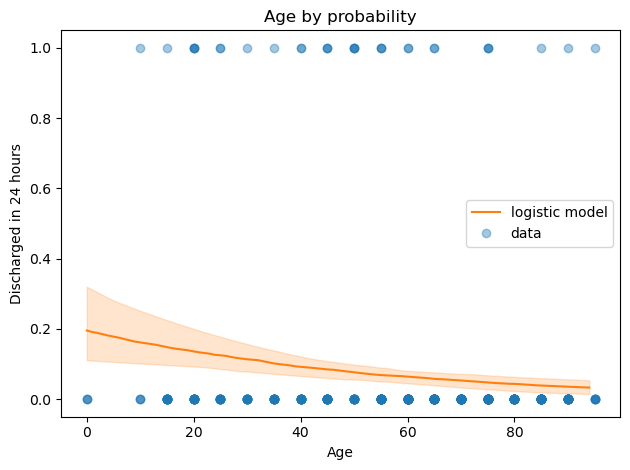

In [85]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
plt.fill_between(ages, low, high, color='C1', alpha=0.2)
plt.plot(ages, median, color='C1', label='logistic model')

plot_data(df)

what is the probability for an individual patient?